### Data preprocessing, preparation of the appropriate time series data generator

In [ ]:
import datetime
import time
from os import listdir
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns
from IPython.display import display

In [2]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)
mpl.rcParams["figure.figsize"] = (12, 12)
mpl.rcParams["axes.grid"] = False

In [3]:
# Location of source files
STATIONS_DIR = "../stations"
LOCATION_DATA_FILE = "../location_data.csv"
# translate Polish column names into English properly formatted names
NEW_COLUMN_NAMES = {
    "Temperatura przy gruncie 5cm": "air_temperature_5cm",
    "Temperatura powietrza 0,5m": "air_temperature_50cm",
    "Temperatura powietrza 2m": "air_temperature_200cm",
    "Temperatura gleby -5cm": "ground_temperature_5cm",
    "Temperatura gleby -10cm": "ground_temperature_10cm",
    "Temperatura gleby -20cm": "ground_temperature_20cm",
    "Temperatura gleby -50cm": "ground_temperature_50cm",
    "Wilgotność powietrza 0,5m": "air_humidity_50cm",
    "Wilgotność powietrza 2m": "air_humidity_200cm",
    "Prędkość wiatru": "wind_speed",
    "Prędkość wiatru max.": "max_wind_speed",
    "Prędkość wiatru min.": "min_wind_speed",
    "Kierunek wiatru": "wind_direction",
    "Promieniowanie": "radiation",
    "Ciśnienie atmosferyczne": "atmospheric_pressure",
    "Ciśnienie atm. zredukowane": "atmospheric_pressure_reduced",
    "Opad chwilowy": "temporary_rainfall",
    "Suma opadu": "total_precipitation",
    "Wilgotność sciółki": "litter_moisture",
}

In [9]:
def get_values_linearly(start, stop, gaps):
    intervals = gaps + 1
    delta = stop - start
    step = delta / intervals
    return [start + (i + 1) * step for i in range(gaps)]


def df_gap_fix(df, max_gap=6 * 24, exclude_collumns=None):
    if exclude_collumns is None:
        exclude_collumns = []
    collumns = [c for c in df.columns if c not in exclude_collumns]

    for collumn_name in collumns:

        column = df[collumn_name]
        values = column.to_list()
        null_id = column.isnull().to_list()

        ids_to_fill = []
        tmp_ids = []

        for i, (v, n) in enumerate(zip(values, null_id)):
            if n:
                tmp_ids.append(i)
            else:
                if tmp_ids and len(tmp_ids) <= max_gap:
                    ids_to_fill.append(tmp_ids)
                tmp_ids = []

        if not ids_to_fill:
            continue

        if ids_to_fill[0][0] == 0:
            ids_to_fill = ids_to_fill[1:]

        if ids_to_fill[-1][-1] == len(values):
            ids_to_fill = ids_to_fill[:-1]

        for id_to_fill in ids_to_fill:
            gap_len = len(id_to_fill)
            start_value = values[id_to_fill[0] - 1]
            stop_value = values[id_to_fill[-1] + 1]
            updatet_values = get_values_linearly(start_value, stop_value, gap_len)

            for val, idx in zip(updatet_values, id_to_fill):
                values[idx] = val

        df[collumn_name] = values

    return df


def get_location_coords():
    location_data = pd.read_csv(LOCATION_DATA_FILE)
    location_data.drop_duplicates(subset="location", inplace=True)
    max_x = max(location_data["x"])
    max_y = max(location_data["y"])
    min_x = min(location_data["x"])
    min_y = min(location_data["y"])
    location_data["x"] = (location_data["x"] - min_x) / (max_x - min_x)
    location_data["y"] = (location_data["y"] - min_y) / (max_y - min_y)
    locations_coords = {}
    for i, row in location_data.iterrows():
        k = row["location"].replace(" ", "_").lower()
        locations_coords[k] = [row["x"], row["y"]]

    return locations_coords

In [10]:
def prepare_dataframe_sequence(station_name, first_year=2015, last_year=2021):
    station_path = join(STATIONS_DIR, station_name)
    csv_files = [f for f in listdir(station_path) if f.endswith(".csv")]
    csv_files.sort()
    csv_files = [
        f for f in csv_files if int(f[:4]) >= first_year - 1 and int(f[:4]) <= last_year
    ]
    data = pd.concat(
        [
            pd.read_csv(join(station_path, file), on_bad_lines="skip")
            for file in csv_files
        ]
    )

    data.drop_duplicates(subset="timestamp", inplace=True)
    data.sort_values("timestamp", inplace=True)

    # The columns we do not use describe the technical parameters of the weather station
    data = data.drop(["Napięcie akumulatora", "Zasilanie", "Obudowa"], axis=1)
    for old_name, new_name in NEW_COLUMN_NAMES.items():
        data[new_name] = data.pop(old_name)

    data.set_index(pd.DatetimeIndex(data["datetime"]), inplace=True)
    data.index = pd.to_datetime(data.index, unit="s")
    data["station"] = station_name

    return data

In [11]:
def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e


def add_nan(xs, n):
    shape = np.array(xs.shape)
    shape[0] += n
    e = np.empty(shape, dtype=xs.dtype)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs
    else:
        e[n:] = np.nan
        e[:n] = xs
    return e

In [21]:
class WindowGenerator:
    def __init__(
        self,
        stations=None,
        first_train_season=2017,
        first_val_season=2020,
        first_test_season=2021,
        last_test_season=2021,
        gap_strategy=None,
        # gap_strategy='linear',
        max_gap_fix=6 * 2,
        scaling="standarization",
    ):

        if stations is None:
            stations = ["starachowice_(kutery)", "skrwilno"]

        self.gap_strategy = gap_strategy
        self.scaling = scaling
        self.stations = stations
        self.dataframes = [
            prepare_dataframe_sequence(
                s, first_year=first_train_season, last_year=last_test_season
            )
            for s in self.stations
        ]

        self.coords = get_location_coords()

        self.base_period = pd.tseries.offsets.Minute() * 10
        self.offset = self.base_period * 6 * 13

        day = 24 * 60 * 60
        year = (365.2425) * day

        self.split_date_val = datetime.datetime(first_val_season, 1, 1)
        self.split_date_test = datetime.datetime(first_test_season, 1, 1)

        for dataframe in self.dataframes:

            # transform timestamp to "Time of day" and "Time of year" signals
            dataframe["day_sin"] = dataframe.apply(
                lambda row: np.sin(row.timestamp * (2 * np.pi / day)), axis=1
            )
            dataframe["day_cos"] = dataframe.apply(
                lambda row: np.cos(row.timestamp * (2 * np.pi / day)), axis=1
            )
            dataframe["year_sin"] = dataframe.apply(
                lambda row: np.sin(row.timestamp * (2 * np.pi / year)), axis=1
            )
            dataframe["year_cos"] = dataframe.apply(
                lambda row: np.cos(row.timestamp * (2 * np.pi / year)), axis=1
            )

            # fill gaps with linear value aproximation
            to_exclude = [
                "timestamp",
                "datetime",
                "day_sin",
                "day_cos",
                "year_sin",
                "year_cos",
                "litter_moisture",
            ]
            if self.gap_strategy == "linear":
                dataframe = df_gap_fix(
                    dataframe, exclude_collumns=to_exclude, max_gap=max_gap_fix
                )

            # convert wind to vector (x, y) reprezentation
            wv = dataframe.pop("wind_speed")
            max_wv = dataframe.pop("max_wind_speed")
            min_wv = dataframe.pop("min_wind_speed")
            # Convert to radians.
            wd_rad = dataframe.pop("wind_direction") * np.pi / 180
            # Calculate the wind x and y components.
            dataframe["wind_x"] = wv * np.cos(wd_rad)
            dataframe["wind_y"] = wv * np.sin(wd_rad)
            dataframe["max_wind_x"] = max_wv * np.cos(wd_rad)
            dataframe["max_wind_y"] = max_wv * np.sin(wd_rad)
            dataframe["min_wind_x"] = min_wv * np.cos(wd_rad)
            dataframe["min_wind_y"] = min_wv * np.sin(wd_rad)

        # drop first and last rows, to have only full days
        for df in self.dataframes:
            first_hour = df.index.hour[0]
            first_minute = df.index.minute[0]
            last_hour = df.index.hour[-1]
            last_minute = df.index.minute[-1]

            drop_first = ((24 - first_hour) * 6 - first_minute // 10) % (6 * 24)
            drop_last = last_hour * 6 + last_minute // 10 + 1

            df.drop(index=df.index[:drop_first], axis=0, inplace=True)
            if drop_last:
                df.drop(index=df.index[-drop_last:], axis=0, inplace=True)

        for i in range(len(self.dataframes)):
            for time, group in self.dataframes[i].groupby(pd.Grouper(freq="D")):
                morning_idx = group["litter_moisture"].at_time("9:00").index[0]
                afternoon_idx = group["litter_moisture"].at_time("13:00").index[0]

                if np.isnan(group.loc[morning_idx, "litter_moisture"]):
                    idx = (
                        group["litter_moisture"]
                        .between_time("9:10", "12:50")
                        .first_valid_index()
                    )
                    first_valid_value = (
                        group["litter_moisture"].loc[idx] if idx is not None else None
                    )
                    if first_valid_value:
                        self.dataframes[i].loc[
                            morning_idx, "litter_moisture"
                        ] = first_valid_value

                if np.isnan(group.loc[afternoon_idx, "litter_moisture"]):
                    idx = (
                        group["litter_moisture"]
                        .between_time("13:10", "23:50")
                        .first_valid_index()
                    )
                    first_valid_value = (
                        group["litter_moisture"].loc[idx] if idx is not None else None
                    )
                    if first_valid_value:
                        self.dataframes[i].loc[
                            afternoon_idx, "litter_moisture"
                        ] = first_valid_value

        # Concat all train data to get std and mean for normalizatio purpose
        train_df_all = pd.concat(
            [df.loc[: self.split_date_val] for df in self.dataframes]
        )

        # for standarization
        self.train_std = train_df_all.std(numeric_only=True)
        self.train_mean = train_df_all.mean(numeric_only=True)

        # for normalization
        self.train_min = train_df_all.min(numeric_only=True)
        self.train_max = train_df_all.max(numeric_only=True)

        if self.scaling is None:
            pass
        elif self.scaling == "standarization":
            for i in range(len(self.dataframes)):

                datetime_tmp = self.dataframes[i].pop("datetime")
                self.dataframes[i] = (
                    self.dataframes[i] - self.train_mean
                ) / self.train_std
                self.dataframes[i]["datetime"] = datetime_tmp

        elif self.scaling == "normalization":
            for i in range(len(self.dataframes)):
                datetime_tmp = self.dataframes[i].pop("datetime")
                self.dataframes[i] = (self.dataframes[i] - self.train_min) / (
                    self.train_max - self.train_min
                )
                self.dataframes[i]["datetime"] = datetime_tmp

        else:
            raise ValueError("scaling can be only None standarization or normalization")

    def get_data_generators(
        self,
        data_format="channels_last",
        intervals=None,
        base_seq_len=30,
        other_seq_len=None,
        batch_size=32,
        features_cols=None,
        include_coords=True,
        use_previous_y=True,
        replace=False,
    ):

        if intervals is None:
            intervals = [3, 6, 6 * 24]

        if other_seq_len is None:
            other_seq_len = [base_seq_len for _ in range(len(intervals))]

        if features_cols is None:
            features_cols = [
                "datetime",
                "air_temperature_50cm",
                "ground_temperature_10cm",
                "air_humidity_50cm",
            ]

        target_cols = ["litter_moisture"]
        base_length = 0
        scaled_length = [0 for i in range(len(intervals))]

        lenghts = []
        dataframe = []

        y = []
        base_x = []
        indices = []
        train_mask, val_mask, test_mask = [], [], []

        resample_dfs = [[] for i in range(len(intervals))]
        resample_idxs = [[] for i in range(len(intervals))]
        coords = []

        for station_n, df in enumerate(self.dataframes):
            if include_coords:
                station_coords = self.coords.get(self.stations[station_n], None)
                if station_coords is None:
                    continue

            station_base_x = (
                df[features_cols].resample(self.base_period, offset=0).first()
            )
            station_y = df[target_cols].resample(self.base_period, offset=0).first()

            station_indices = station_y.at_time("13:00").dropna().index
            if not use_previous_y:
                print("use_previous_y")
                morning_indices = station_y.at_time("09:00").dropna().index
                station_indices = station_indices.union(morning_indices)

            station_train_mask = [
                1 if x <= self.split_date_val else 0 for x in station_indices
            ]
            station_val_mask = [
                1 if x > self.split_date_val and x <= self.split_date_test else 0
                for x in station_indices
            ]
            station_test_mask = [
                1 if x > self.split_date_test else 0 for x in station_indices
            ]

            station_resample_dfs = [
                station_base_x.resample(
                    self.base_period * interval, offset=self.offset
                ).first()
                for interval in intervals
            ]
            station_resample_idxs = [
                resampled.index.searchsorted(station_indices)
                for resampled in station_resample_dfs
            ]
            station_indices = [station_y.index.get_loc(idx) for idx in station_indices]

            print(len(station_indices))
            print(
                len(station_resample_idxs[0]),
                len(station_resample_idxs[1]),
                len(station_resample_idxs[2]),
            )

            forbidden = []
            for i in range(len(station_indices)):
                if station_indices[i] < base_seq_len:
                    forbidden.append(i)
                    continue
                if (
                    use_previous_y
                    and station_y.iloc[station_indices[i] - 6 * 4].isna()[0]
                ):
                    forbidden.append(i)
                    continue
                if (
                    station_base_x.iloc[
                        station_indices[i] - base_seq_len : station_indices[i]
                    ]
                    .isnull()
                    .values.any()
                ):
                    forbidden.append(i)
                    continue

                for j in range(len(station_resample_idxs)):
                    if station_resample_idxs[j][i] < other_seq_len[j]:
                        forbidden.append(i)
                        break
                    if (
                        station_resample_dfs[j]
                        .iloc[
                            station_resample_idxs[j][i]
                            - other_seq_len[j] : station_resample_idxs[j][i]
                        ]
                        .isnull()
                        .values.any()
                    ):
                        forbidden.append(i)
                        break

            indices_lenght = len(station_indices)
            station_indices = [
                station_indices[i] + base_length
                for i in range(indices_lenght)
                if i not in forbidden
            ]

            station_train_mask = [
                station_train_mask[i]
                for i in range(indices_lenght)
                if i not in forbidden
            ]
            station_val_mask = [
                station_val_mask[i] for i in range(indices_lenght) if i not in forbidden
            ]
            station_test_mask = [
                station_test_mask[i]
                for i in range(indices_lenght)
                if i not in forbidden
            ]

            station_resample_idxs = [
                [
                    station_resample_idx[i] + scaled_length[j]
                    for i in range(indices_lenght)
                    if i not in forbidden
                ]
                for j, station_resample_idx in enumerate(station_resample_idxs)
            ]

            print(len(station_indices))
            print(
                len(station_resample_idxs[0]),
                len(station_resample_idxs[1]),
                len(station_resample_idxs[2]),
            )

            y.append(station_y)
            base_x.append(station_base_x)
            indices.extend(station_indices)
            train_mask.extend(station_train_mask)
            val_mask.extend(station_val_mask)
            test_mask.extend(station_test_mask)

            base_length += len(station_base_x)
            for pos in range(len(intervals)):
                resample_idxs[pos].extend(station_resample_idxs[pos])
                resample_dfs[pos].append(station_resample_dfs[pos])
                scaled_length[pos] += len(station_resample_dfs[pos])

            if include_coords:
                coords.extend([station_coords for _ in range(len(station_indices))])

        y = pd.concat(y)
        y = y.to_numpy()
        if use_previous_y:
            y_morning = shift(y, 6 * 4)
        indices = np.array(indices)
        resample_idxs = [np.array(resample_idx) for resample_idx in resample_idxs]
        coords = np.array(coords)

        base_x = pd.concat(base_x)
        for pos in range(len(intervals)):
            resample_dfs[pos] = pd.concat(resample_dfs[pos])

        base_window = add_nan(
            np.lib.stride_tricks.sliding_window_view(
                base_x.to_numpy(), window_shape=base_seq_len, axis=0
            ),
            base_seq_len,
        )
        if data_format == "channels_last":
            base_window = np.moveaxis(base_window, -1, -2)

        other_window = [
            add_nan(
                np.lib.stride_tricks.sliding_window_view(
                    df.to_numpy(), window_shape=seq_len, axis=0
                ),
                seq_len,
            )
            for df, seq_len in zip(resample_dfs, other_seq_len)
        ]

        if data_format == "channels_last":
            for i in range(len(other_window)):
                other_window[i] = np.moveaxis(other_window[i], -1, -2)

        positions = np.arange(0, len(indices))
        train_positions = [positions[i] for i in range(len(indices)) if train_mask[i]]
        val_positions = [positions[i] for i in range(len(indices)) if val_mask[i]]
        test_positions = [positions[i] for i in range(len(indices)) if test_mask[i]]

        train_gen = self._get_generator(
            train_positions,
            y,
            indices,
            resample_idxs,
            base_window,
            other_window,
            batch_size,
            replace,
            y_morning=y_morning,
            coords=coords,
        )

        val_gen = self._get_generator(
            val_positions,
            y,
            indices,
            resample_idxs,
            base_window,
            other_window,
            batch_size,
            replace,
            y_morning=y_morning,
            coords=coords,
        )

        test_gen = self._get_generator(
            test_positions,
            y,
            indices,
            resample_idxs,
            base_window,
            other_window,
            batch_size,
            replace,
            y_morning=y_morning,
            coords=coords,
        )

        return train_gen, val_gen, test_gen

    def _get_generator(
        self,
        positions,
        y,
        indices,
        resample_idxs,
        base_window,
        other_window,
        batch_size,
        replace,
        y_morning=None,
        coords=None,
    ):

        while True:
            selected = np.random.choice(positions, batch_size, replace=replace)

            y_batch = y[indices[selected]]
            x_batch = [base_window[indices[selected], :, :]]
            for pos in range(len(resample_idxs)):
                x_batch.append(other_window[pos][resample_idxs[pos][selected], :, :])

            if y_morning is not None:
                x_batch.insert(0, y_morning[indices[selected]])

            if coords is not None:
                x_batch.insert(0, coords[selected])

            yield x_batch, y_batch

In [ ]:
wg = WindowGenerator(
    scaling=None, gap_strategy="linear", stations=["starachowice_(kutery)"]
)

In [26]:
train_gen, val_gen, test_gen = wg.get_data_generators()

channels_last
1113
1113 1113 1113
954
954 954 954
303552
[101184, 50592, 2109]
[157, 173, 174, 175, 176, 177, 178, 179, 180, 208, 209, 210, 236, 259, 274, 331, 332, 333, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 427, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 546, 585, 587, 588, 590, 591, 592, 599, 647, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 746, 757, 763, 765, 782, 788, 797, 800, 801, 802, 837, 838, 839, 949, 956, 1053]
(303553, 4, 30)
(303553, 30, 4)
(101185, 30, 4)


In [61]:
x_batch, y_batch = next(test_gen)

Text(0, 0.5, 'timestamp')

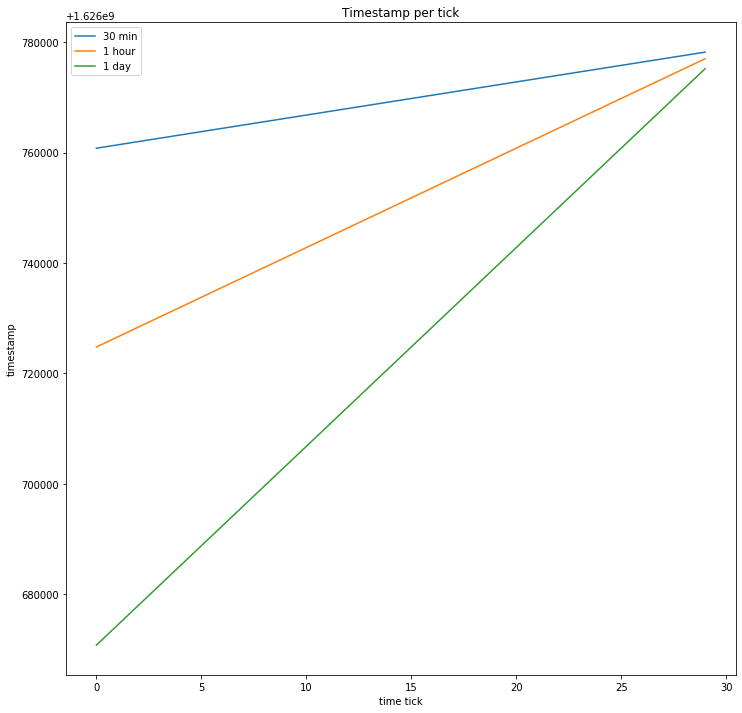

In [58]:
# Timestamp plot in different time scales
plt.plot(
    [
        time.mktime(
            datetime.datetime.strptime(str_datetime, "%Y-%m-%d %H:%M:%S").timetuple()
        )
        for str_datetime in x_batch[2][0, :, 0]
    ]
)
plt.plot(
    [
        time.mktime(
            datetime.datetime.strptime(str_datetime, "%Y-%m-%d %H:%M:%S").timetuple()
        )
        for str_datetime in x_batch[3][0, :, 0]
    ]
)
plt.plot(
    [
        time.mktime(
            datetime.datetime.strptime(str_datetime, "%Y-%m-%d %H:%M:%S").timetuple()
        )
        for str_datetime in x_batch[4][0, :, 0]
    ]
)
plt.legend(["30 min", "1 hour", "1 day"])
plt.title("Timestamp per tick")
plt.xlabel("time tick")
plt.ylabel("timestamp")

Text(0, 0.5, 'temperature')

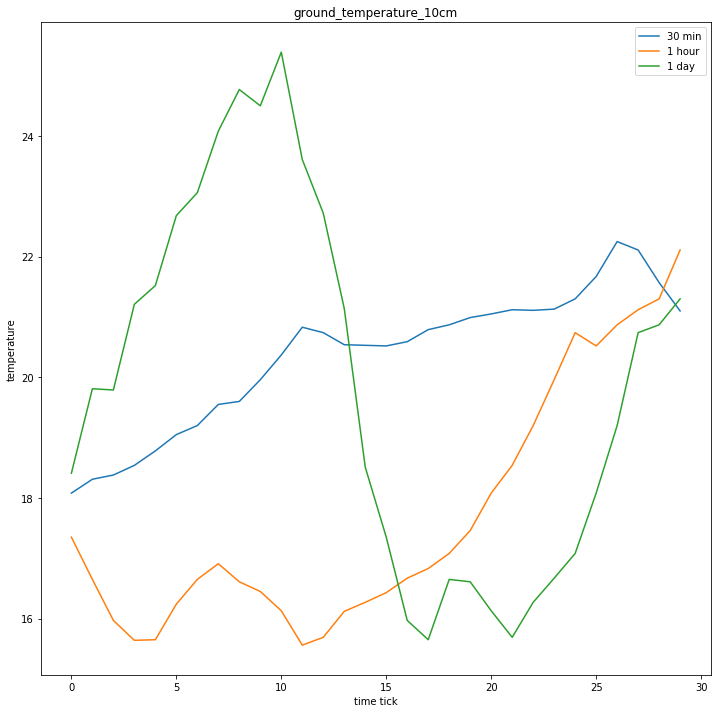

In [59]:
# Temperature plot in different time scales
# we see that the values coincide with the end of the time series.
plt.plot(x_batch[2][0, :, 1])
plt.plot(x_batch[3][0, :, 1])
plt.plot(x_batch[4][0, :, 1])
plt.legend(["30 min", "1 hour", "1 day"])
plt.title("ground_temperature_10cm")
plt.xlabel("time tick")
plt.ylabel("temperature")